In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import model_selection, preprocessing
# import seaborn as sns
%matplotlib inline
import xgboost as xgb
from sklearn import linear_model
import operator

### Read the data and check the shapes

In [14]:
def load_data():
    train_df = pd.read_csv('./data/train.csv')
    x_test_df = pd.read_csv('./data/test.csv')
    
    y_train = train_df['price_doc'].as_matrix()
    x_train_df = train_df.drop(['price_doc'],1)
    return (x_train_df, y_train, x_test_df)

#x_train_df, y_train, x_test_df = load_data()

def impute_data(df):
    columns_with_nulls = df.columns[df.isnull().any()].tolist()
    string_columns = df.select_dtypes(include=['object']).columns.tolist()

    for col in columns_with_nulls:
        if col in string_columns:
            #populate the most common categorical value
            df[col] = df[col].fillna(df[col].value_counts().index[0])
        else:
            #populate with mean of column for missing values
            df[col] = df[col].fillna(np.mean(df[col]))
    return df   

def add_features(df):
    x_dt = pd.to_datetime(df['timestamp'],format='%Y-%m-%d')
    df['year'] = x_dt.dt.year
    df['month'] =  x_dt.dt.month
    df['day'] = x_dt.dt.day
    df['quarter'] = x_dt.dt.quarter
    df['days_since'] = (x_dt - x_dt.min()).astype('timedelta64[D]')
    return df

def onehot_encode(df,include_string_cols=True,other_cols=[]):
    cols = other_cols
    if include_string_cols:
        cols = cols.append(df.select_dtypes(include=['object']).columns.tolist())
    return pd.get_dummies(df,columns=cols)

In [221]:
#load data
x_train_df, y_train, x_test_df = load_data()

#we should on-hot encode test and train togather as labels should math
x_all_df = x_train_df.append(x_test_df)
string_columns = x_train_df.select_dtypes(include=['object']).columns.tolist()

#one hot encode string columns
x_all_onehot_df = pd.get_dummies(x_all_df,columns=string_columns)
print('shape after onehot encoding: ', x_all_onehot_df.shape)

#again separate train and test features
x_train_onehot = x_all_onehot_df[0:x_train_df.shape[0]].as_matrix()
x_test_onehot = x_all_onehot_df[x_train_df.shape[0]::].as_matrix()

('shape after onehot encoding: ', (38133, 1887))


### Train the model

In [140]:
model = xgb.XGBRegressor()
model.fit(x_train_onehot, y_train)

XGBRegressor(base_score=0.5, colsample_bytree=1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
       n_estimators=100, nthread=-1, objective='reg:linear', seed=0,
       silent=True, subsample=1)

In [141]:
y_test = model.predict(x_test_onehot)
# y_pred = model.predict()

### Submission 1
So we are submitting without any feature engineering or parameter optmization for xgboost. Some columns could also be wrongly classified as string columns and one-hot encoded

In [142]:
submission = pd.DataFrame({
    'id': x_test['id'],
    'price_doc': y_test
})
submission.to_csv('./data/submission_v0.12.csv',index=False)

#Ranked 836 and score was 0.32577

### Submission 2

In [24]:
x_train_df, y_train, x_test_df = load_data()

#we should on-hot encode test and train togather as labels should math
x_all_df = x_train_df.append(x_test_df)
string_columns = x_train_df.select_dtypes(include=['object']).columns.tolist()

#let us check what the string columns are
string_columns

['timestamp',
 'product_type',
 'sub_area',
 'culture_objects_top_25',
 'thermal_power_plant_raion',
 'incineration_raion',
 'oil_chemistry_raion',
 'radiation_raion',
 'railroad_terminal_raion',
 'big_market_raion',
 'nuclear_reactor_raion',
 'detention_facility_raion',
 'water_1line',
 'big_road1_1line',
 'railroad_1line',
 'ecology']

Timestamp is getting identifed as string. Lets fix this

In [26]:
x_all_df = add_features(x_all_df)

#one hot encode string columns
string_columns = x_train_df.select_dtypes(include=['object']).columns.tolist()
x_all_onehot_df = pd.get_dummies(x_all_df,columns=string_columns)
print('shape after onehot encoding: ', x_all_onehot_df.shape)

#again separate train and test features
x_train_onehot = x_all_onehot_df[0:x_train_df.shape[0]].as_matrix()
x_test_onehot = x_all_onehot_df[x_train_df.shape[0]::].as_matrix()

#train
model = xgb.XGBRegressor(max_depth=6,learning_rate=0.05)
model.fit(x_train_onehot, y_train)

#predict
y_test = model.predict(x_test_onehot)

submission = pd.DataFrame({
    'id': x_test_df['id'],
    'price_doc': y_test
})
submission.to_csv('./data/submission_v0.31.csv',index=False)


('shape after onehot encoding: ', (38133, 1892))


In [21]:

submission = pd.DataFrame({
    'id': x_test_df['id'],
    'price_doc': y_test
})
submission.to_csv('./data/submission_v0.3.csv',index=False)

1. result is 0.33636 (if I drop datetime column), which is worse than submisison 1
2. result is 0.32501 and rank is 767, if I retain the timestamp column, and increase the max_depth to 6 and change learning rate to 0.05
3. result is 0.34385, when I increased depth to 20 and added the feature 'days_since'
4. result is 0.32798, when I set max_depth to 6
5. result is 0.32501. So 'days_since' has no impact


In [ ]:
#we should on-hot encode test and train togather as labels should math
# x_all_df = x_train_df.append(x_test_df)

#one hot encode string columns
x_all_onehot_df = pd.get_dummies(x_all_df,columns=string_columns)
print('shape after onehot encoding: ', x_all_onehot_df.shape)

#again separate train and test features
x_train_onehot = x_all_onehot_df[0:x_train_df.shape[0]].as_matrix()
x_test_onehot = x_all_onehot_df[x_train_df.shape[0]::].as_matrix()

#train
model = xgb.XGBRegressor(max_depth=6,learning_rate=0.1)
model.fit(x_train_onehot, y_train)

#predict
y_test = model.predict(x_test_onehot)


submission_v4 = pd.DataFrame({
    'id': x_test['id'],
    'price_doc': y_test
})
submission_v4.to_csv('./data/submission_v0.4.csv',index=False)

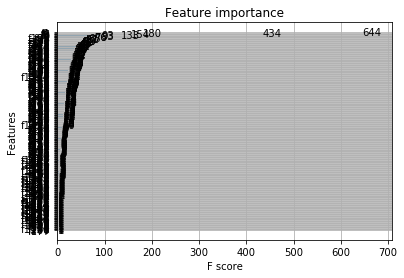

In [267]:
xgb.plot_importance(model.booster())
# plt.bar(range(len(model.feature_importances_)), model.feature_importances_)
# plt.show()

### Regression - time series
trees cannot take advantage of the time series information - my understanding (could be wrong). So let us try regression and combine the results

In [15]:
x_train_df, y_train, x_test_df = load_data()
x_all_df = x_train_df.append(x_test_df)
x_all_df = impute_data(x_all_df)

columns_with_nulls = x_all_df.columns[x_all_df.isnull().any()].tolist()
x_all_df = add_features(x_all_df)
x_all_df = x_all_df.drop('timestamp',axis=1)
# x_all_df = x_all_df.drop(columns_with_nulls,axis=1)

#one hot encode string columns
x_all_onehot_df = onehot_encode(x_all_df,other_cols=['month','quarter'])
# columns_with_nulls = x_all_df.colxgb.plot_importance(bst)umns[x_all_df.isnull().any()].tolist()

In [244]:
regr = linear_model.LinearRegression()
regr.fit(x_all_onehot_df[0:x_train_df.shape[0]].as_matrix(),y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [245]:
regr_y_pred = regr.predict(x_all_onehot_df[x_train_df.shape[0]::].as_matrix())

submission_v5 = pd.DataFrame({
    'id': x_test['id'],
    'price_doc': regr_y_pred
})
submission_v5.to_csv('./data/submission_regr_v0.5.csv',index=False)

In [17]:
x_all_onehot_df.columns

Index([u'id', u'full_sq', u'life_sq', u'floor', u'max_floor', u'material',
       u'build_year', u'num_room', u'kitch_sq', u'state',
       ...
       u'water_1line_yes', u'big_road1_1line_no', u'big_road1_1line_yes',
       u'railroad_1line_no', u'railroad_1line_yes', u'ecology_excellent',
       u'ecology_good', u'ecology_no data', u'ecology_poor',
       u'ecology_satisfactory'],
      dtype='object', length=457)